# Set Up

In [1]:
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

file_path = './gold_futures.csv'

# Data Loading

In [2]:
def load_data(file_path):
    """
    Load gold futures data from a CSV file.
    
    Parameters:
        file_path (str): Path to the CSV file containing gold futures data
        
    Returns:
        DataFrame: Pandas DataFrame with loaded data
    """
    
    data = pd.read_csv('./gold_futures.csv',index_col = 0, parse_dates=True)
    # Convert 'Price' to numeric
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data.sort_index(inplace=True)
    return data

In [3]:
def get_log_returns(data):
    data["Returns"] = data["Price"].pct_change().fillna(0)
    return data

# Training & Test Split

In [90]:
def prepare_training_data(data, train_ratio=0.95, returns = False):
    """
    Extract feature columns and split data into training and testing sets.
    
    Parameters:
        data (DataFrame): Preprocessed data
        train_ratio (float): Ratio of data to use for training (default: 0.95)
        
    Returns:
        tuple: (training data, test data, scaler)
    """
    if returns:
        rtn_data = get_log_returns(data).filter(["Returns"])
        dataset = rtn_data.values
    else:
        price_data = data.filter(["Price"])
        dataset = price_data.values
    
    # Determine train/test split point
    training_size = int(np.ceil(len(dataset) * train_ratio))
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    # Split into train and test sets
    train_data = scaled_data[:training_size]
    test_data = scaled_data[training_size:]
    
    return train_data, test_data, scaler

In [50]:
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM model input.
    
    Parameters:
        data (ndarray): Input data array
        seq_length (int): Length of sequence for LSTM input
        
    Returns:
        tuple: (X sequences, y targets)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    
    return np.array(X), np.array(y)

# Model

In [61]:
def build_model(input_shape):
    """
    Build and compile LSTM model.
    
    Parameters:
        input_shape (tuple): Shape of input data
        
    Returns:
        Model: Compiled LSTM model
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    learning_rate = 0.0008
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
    return model

In [52]:
def train_model(model, X_train, y_train, epochs=40):
    """
    Train the LSTM model.
    
    Parameters:
        model: LSTM model to train
        X_train (ndarray): Training features
        y_train (ndarray): Training targets
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr], 
        validation_split=0.2
    )
    return history

# Evaluation

In [53]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAPE value as percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [54]:
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate model performance on test data.
    
    Parameters:
        model: Trained model
        X_test (ndarray): Test features
        y_test (ndarray): Test targets
        scaler: Fitted scaler for inverse transformation
        
    Returns:
        tuple: (predictions DataFrame, MAPE score)
    """
    # Make predictions
    pred = model.predict(X_test)
    
    # Inverse transform to get actual values
    y_test_inv = scaler.inverse_transform(y_test)
    pred_inv = scaler.inverse_transform(pred)
    
    # Create results DataFrame
    test = pd.DataFrame({
        'actual': y_test_inv.flatten(),
        'pred': pred_inv.flatten()
    })
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test['actual'], test['pred'])
    
    return test, mape

In [55]:
def plot_results(actual, predicted, title="Gold Futures Price Prediction"):
    """
    Plot actual vs predicted values.
    
    Parameters:
        actual (array): Actual price values
        predicted (array): Predicted price values
        title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Run

## Model 1

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3478 - root_mean_squared_error: 1.0966 - val_loss: 0.6449 - val_root_mean_squared_error: 0.7505 - learning_rate: 8.0000e-04
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2154 - root_mean_squared_error: 1.0699 - val_loss: 0.6031 - val_root_mean_squared_error: 0.7474 - learning_rate: 8.0000e-04
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2022 - root_mean_squared_error: 1.0783 - val_loss: 0.5891 - val_root_mean_squared_error: 0.7501 - learning_rate: 8.0000e-04
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2655 - root_mean_squared_error: 1.1111 - val_loss: 0.5745 - val_root_mean_squared_error: 0.7471 - learning_rate: 8.0000e-04
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2583 - root_mean_squared_error: 1.1147 - val_loss: 0.5720 - val_root_mean_squared_error: 0.7494 - learning_rate: 8.0000e-04
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1944

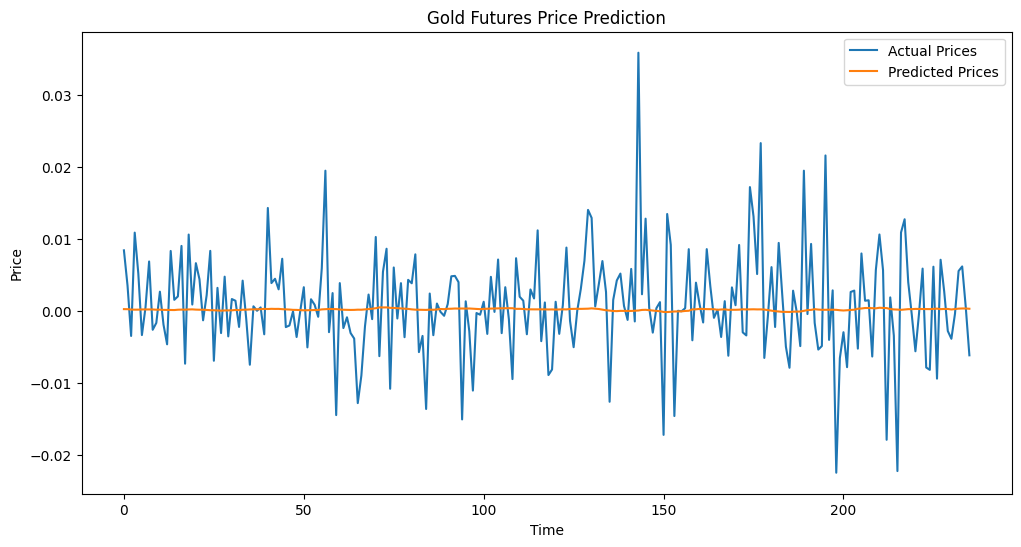

In [91]:
# Load and preprocess data
data = load_data(file_path)

# Prepare training data
train_data, test_data, scaler = prepare_training_data(data, returns = True)

# Set sequence length
seq_length = 14

# Create sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build and train model
model = build_model((seq_length, 1))
history = train_model(model, X_train, y_train)

# Evaluate model
results, mape = evaluate_model(model, X_test, y_test, scaler)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot results
plot_results(results['actual'], results['pred'], "Gold Futures Price Prediction")

## Model 2

In [92]:
def build_enhanced_model(input_shape):
    """
    Build and compile an enhanced LSTM model.
    
    Parameters:
        input_shape (tuple): Shape of input data
        
    Returns:
        Model: Compiled enhanced LSTM model
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # First LSTM layer with more units
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, 
                               kernel_regularizer=regularizers.L2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(Bidirectional(LSTM(units=64, kernel_regularizer=regularizers.L2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_regularizer=regularizers.L2(0.002), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))

    learning_rate = 0.0005  # Slightly lower learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                 metrics=[RootMeanSquaredError()])
    
    return model

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 3.7031 - root_mean_squared_error: 1.6583 - val_loss: 1.4842 - val_root_mean_squared_error: 0.7473 - learning_rate: 5.0000e-04
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.6254 - root_mean_squared_error: 1.3045 - val_loss: 1.4699 - val_root_mean_squared_error: 0.7490 - learning_rate: 5.0000e-04
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.3994 - root_mean_squared_error: 1.2221 - val_loss: 1.4547 - val_root_mean_squared_error: 0.7506 - learning_rate: 5.0000e-04
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.2421 - root_mean_squared_error: 1.1639 - val_loss: 1.4367 - val_root_mean_squared_error: 0.7510 - learning_rate: 5.0000e-04
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.2002 - root_mean_squared_error: 1.1530 - val_loss: 1.4154 - val_root_mean_squared_error: 0.7495 - learning_rate: 5.0000e-04
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1

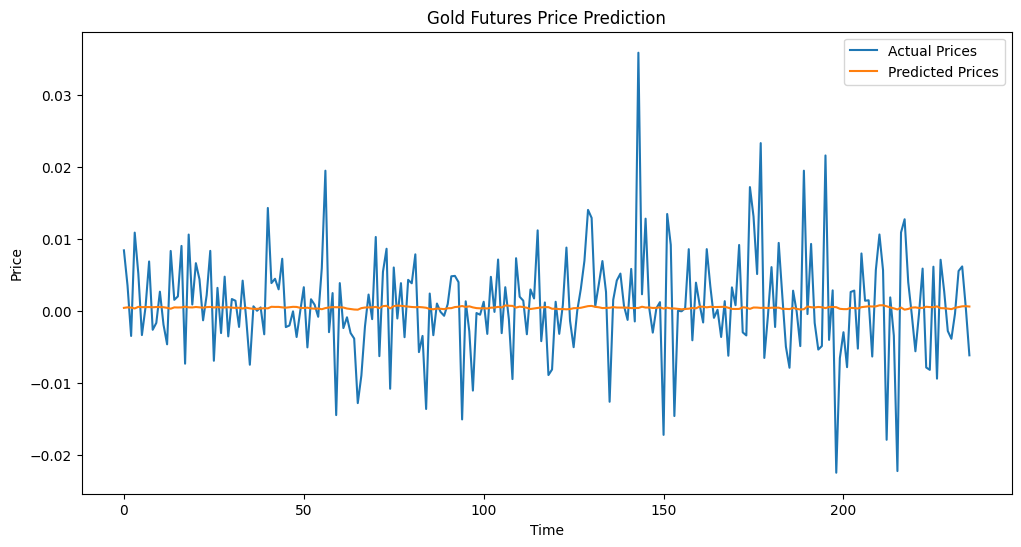

In [93]:
# Build and train enhanced model
enhanced_model = build_enhanced_model((seq_length, 1))
history = train_model(enhanced_model, X_train, y_train)

# Evaluate model
results, mape = evaluate_model(enhanced_model, X_test, y_test, scaler)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot results
plot_results(results['actual'], results['pred'], "Gold Futures Price Prediction")